# LSTM model half of hour

Libraries import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import datetime as dt
import numpy as np
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import load_model


from sklearn.metrics import mean_squared_error, mean_absolute_error

CSV file reading

In [4]:
# Read the CSV file
all_data = pd.read_csv("data_for_main_model/data_ready_for_training.csv")
all_data.drop('Unnamed: 0',axis='columns', inplace=True)
all_data = all_data[["relh", "skph", "temp", "minutes"]]

In [34]:
all_data.head()

,relh,skph,temp
0,100.0,0.000,-2.0
1,100.0,0.000,-2.0
2,100.0,3.704,-2.0
3,100.0,0.000,-2.0
4,100.0,5.556,-3.0


In [5]:
# every 30 min
all_data.drop('minutes',axis='columns', inplace=True)

Tranformation and split data

In [6]:
def standard_score(X, y, index, training_mean, training_std, timestamps_count = 0):
    X[:, :, index] = (X[:, :, index] - training_mean) / training_std
    y[:, index] = (y[:, index] - training_mean) / training_std


def transform_and_split_data(df_input, window_size = 6, test_size = 0.1,  valid_size = 0.1, timestamps_count = 0):
    df = df_input.to_numpy()
    features_len = df_input.shape[1]
    data_count = len(df)
    X = []
    y = []
    # Explanatory X and Response y variables 
    for i in range(data_count-window_size - timestamps_count):
        row = [r for r in df[i:i+window_size]]
        X.append(row)
        label = [df[i+window_size + timestamps_count]]
        y.append(label)
    X = np.array(X)
    y = np.array(y)

    resh0 = y.shape[0]
    resh1 = y.shape[2]
    y = y.reshape(resh0, resh1)
    # data split
    train_size = 1 - test_size - valid_size
    train_last_el = int(data_count * train_size)
    valid_last_el = train_last_el + int(data_count * valid_size)

    X_train, y_train = X[:train_last_el], y[:train_last_el]

    X_val, y_val = X[train_last_el:valid_last_el], y[train_last_el:valid_last_el]
    X_test, y_test = X[valid_last_el:], y[valid_last_el:]

    training_mean = []
    training_std = []
    # data normalization
    for i in range(features_len):
        training_mean.append(np.mean(X[:, :, i]))
        training_std.append(np.std(X[:, :, i]))
        standard_score(X_train, y_train, i, training_mean[i], training_std[i])
        standard_score(X_val, y_val, i, training_mean[i], training_std[i])
        standard_score(X_test, y_test, i, training_mean[i], training_std[i])

    return  X_train, y_train, X_val, y_val, X_test, y_test,training_mean, training_std

LSTM model init, learn and save

In [7]:
# neural network model
def LSTM_model(X_train, y_train, X_val, y_val, epochs =10, learning_rate=0.001, window_size = 6):
    model = Sequential()
    model.add(InputLayer((window_size, 3)))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(32, 'ReLU')) # previous was ReLU
    model.add(Dense(3, 'linear'))
    # model = Sequential()
    # model.add(LSTM(64, return_sequences=True, input_shape=(window_size, 3)))
    # model.add(LSTM(16, 'ReLU')) # previous was ReLU
    # model.add(Dense(32, 'ReLU')) # previous was ReLU
    # model.add(Dense(3, 'linear'))

    # cp = ModelCheckpoint('LSTM_model', save_best_only=True)
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate= learning_rate), metrics=[RootMeanSquaredError()])
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size = 128)#, callbacks=[cp]), shuffle = False
    return model

Make predicitions and plot output

In [8]:
def denormalization(y, training_mean, training_std):
  y = (y*training_std) + training_mean
  return y

def make_predictions(model, X, y,  training_mean, training_std):
  predictions = model.predict(X)
  
  
  features_len = y.shape[1]
  pred = []
  actual =[]

  for i in range(features_len):
    pred.append(denormalization(predictions[:,i], training_mean[i], training_std[i]))
    actual.append(denormalization(y[:,i], training_mean[i], training_std[i]))

  return pred, actual

def plot_predictions_and_actual(pred, actual, start=24, end=48):

  fig, axs = plt.subplots(4)
  fig.suptitle('Weather parameters - red means predicted')
  fig.tight_layout(pad=1.8)
  axs[0].plot(pred[0][start:end],'r')
  axs[0].plot(actual[0][start:end])
  axs[0].set_title('relative humidity')

  axs[1].plot(pred[1][start:end],'r')
  axs[1].plot(actual[1][start:end])
  axs[1].set_title('speed of wind')

  axs[2].plot(pred[2][start:end],'r')
  axs[2].plot(actual[2][start:end])
  axs[2].set_title('temperature')

  axs[3].plot(actual[2][:])
  axs[3].set_title('temperature')




MSE calculations for given window size and etc. for the next 1 to 3 hours

In [9]:
def return_time(window_size,test_size,valid_size,epochs,learning_rate, save_model = False):
    
    MSE_humid = []
    MAE_humid = []

    MSE_wind = []
    MAE_wind = []
    
    MSE_temp = []
    MAE_temp = []

    bias_relh = []
    bias_skph = []
    bias_temp = []

    # MSE calculations for given window size and etc. in next 1 to 3 next hours
    # last_pred_hour == 3 means that predictions are from +1 hour till +3 hours
    last_pred_hour = 6
    for hour in range(1,last_pred_hour,2): # cause every data timestamp is in 30 min distance
        # (hour == 1) it means that predictions will be made for next one hour
        X_train, y_train, X_val, y_val, X_test, y_test,training_mean, training_std = transform_and_split_data(all_data.copy(), window_size, test_size, valid_size, hour) 
        X_test.size
        model = LSTM_model(X_train, y_train, X_val, y_val, epochs, learning_rate, window_size)

        ## save as binary file .pkl
        if(save_model):
            file_name = "lstm_" + str(hour+1)/2 + ".pkl"
            with open(file_name, "xb") as f_1:
                pickle.dump(model, f_1, -1)

        pred, actaul = make_predictions(model, X_test, y_test,  training_mean, training_std)
        MSE_humid.append(mean_squared_error(actaul[0], pred[0]))
        MAE_humid.append(mean_absolute_error(actaul[0], pred[0]))
        MSE_wind.append(mean_squared_error(actaul[1], pred[1]))
        MAE_wind.append(mean_absolute_error(actaul[1], pred[1]))
        MSE_temp.append(mean_squared_error(actaul[2], pred[2]))
        MAE_temp.append(mean_absolute_error(actaul[2], pred[2]))


        bias_relh.append(sum(pred[0] - actaul[0])/len(pred[0]))
        bias_skph.append(sum(pred[1] - actaul[1])/len(pred[0]))
        bias_temp.append(sum(pred[2] - actaul[2])/len(pred[0]))


    return MSE_humid, MAE_humid, MSE_wind, MAE_wind, MSE_temp, MAE_temp, pred, actaul, bias_relh, bias_skph, bias_temp

# Test for 6 and then 12 timestamps (3 and 6 hours)

In [22]:
# test_size = 0.15
# valid_size = 0.15
# epochs = 12
# learning_rate=0.001

# window_size = 6
# MSE_humid_6, MAE_humid_6, MSE_wind_6, MAE_wind_6, MSE_temp_6, MAE_temp_6, pred_6, actaul_6  = return_time(window_size,test_size,valid_size,epochs,learning_rate)
# window_size = 12
# MSE_humid_12, MAE_humid_12, MSE_wind_12, MAE_wind_12, MSE_temp_12, MAE_temp_12, pred_12, actaul_12  = return_time(window_size,test_size,valid_size,epochs,learning_rate)

Epoch 1/12
789/789 [==============================] - 11s 10ms/step - loss: 0.1481 - root_mean_squared_error: 0.3849 - val_loss: 0.0985 - val_root_mean_squared_error: 0.3138
Epoch 2/12
789/789 [==============================] - 6s 7ms/step - loss: 0.1116 - root_mean_squared_error: 0.3341 - val_loss: 0.0957 - val_root_mean_squared_error: 0.3093
Epoch 3/12
789/789 [==============================] - 7s 9ms/step - loss: 0.1086 - root_mean_squared_error: 0.3295 - val_loss: 0.0938 - val_root_mean_squared_error: 0.3063
Epoch 4/12
789/789 [==============================] - 7s 9ms/step - loss: 0.1073 - root_mean_squared_error: 0.3276 - val_loss: 0.0925 - val_root_mean_squared_error: 0.3041
Epoch 5/12
789/789 [==============================] - 9s 11ms/step - loss: 0.1065 - root_mean_squared_error: 0.3263 - val_loss: 0.0929 - val_root_mean_squared_error: 0.3048
Epoch 6/12
789/789 [==============================] - 10s 12ms/step - loss: 0.1057 - root_mean_squared_error: 0.3252 - val_loss: 0.0938 -

In [23]:
# # 3 hours
# print(MAE_humid_6)
# print(MAE_wind_6)
# print(MAE_temp_6)

[3.7925589775209687, 5.669254201749786, 7.195383689028895, 8.772188125864547, 10.246560247923348, 11.472132956898456, 12.213350484509355, 13.180047492158048, 13.63147888119309, 13.948745066454391, 14.124952588350732, 13.875726423723739]
[2.7183604342108034, 3.415425045472483, 3.9571704247210087, 4.486907694932125, 4.921818180719953, 5.211755446661339, 5.433962360057539, 5.634071701025259, 5.722293682990781, 5.848952953516659, 5.864510898454076, 5.87900197493011]
[0.9211943906647112, 1.1212092530024729, 1.5047863970062323, 1.9111636491243291, 2.235701425787874, 2.571775317512088, 2.7597136638756483, 2.977104270340127, 3.0964353746617284, 3.1626257794423727, 3.237022393609577, 3.191239179080533]


In [24]:
# # 6 hours
# print(MAE_humid_12)
# print(MAE_wind_12)
# print(MAE_temp_12)

[3.864147529429056, 5.526440404894086, 7.0590785043411515, 8.472885390099629, 9.746728231851927, 11.037176050574692, 11.637240247022598, 12.134825467284376, 12.453421520131753, 12.808516991429082, 12.45571730566621, 12.417872712271553]
[2.690297357657705, 3.4022327486744017, 3.931063190471681, 4.383619013202917, 4.774702136562352, 5.085165110653418, 5.309383365105474, 5.39418771442958, 5.518904374892573, 5.6128969538710916, 5.611073591229119, 5.620677059427332]
[0.7772716357828234, 1.0918669362105249, 1.454877257667117, 1.8142089620163608, 2.1164373957926492, 2.4214354713537074, 2.5535207596826646, 2.6869180935094654, 2.759887180847736, 2.881243338868458, 2.817267947132911, 2.830132876764255]


Text(0, 0.5, 'MSE')

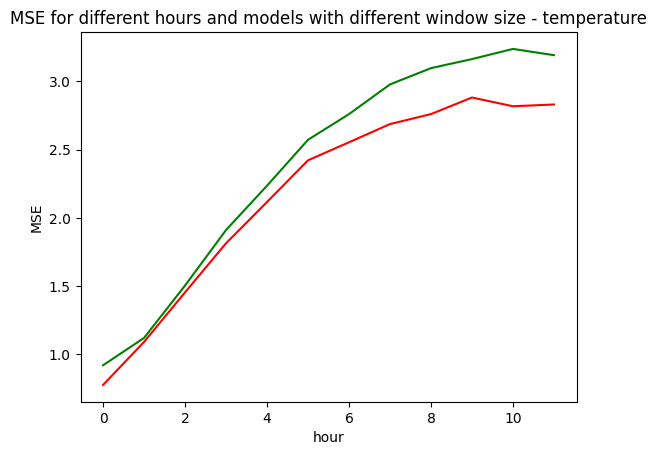

In [25]:
# plt.plot(MAE_temp_6,'g')
# plt.plot(MAE_temp_12,'r')
# plt.title("MSE for different hours and models with different window size - temperature")
# plt.xlabel("hour")
# plt.ylabel("MSE")

Text(0, 0.5, 'MSE')

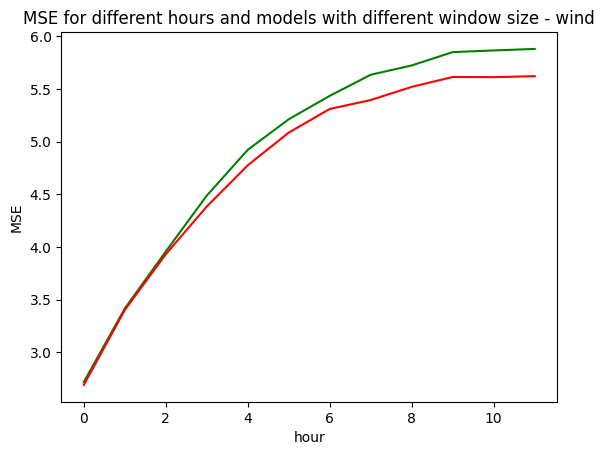

In [27]:
# plt.plot(MAE_wind_6,'g')
# plt.plot(MAE_wind_12,'r')
# plt.title("MSE for different hours and models with different window size - wind")
# plt.xlabel("hour")
# plt.ylabel("MSE")

Text(0, 0.5, 'MSE')

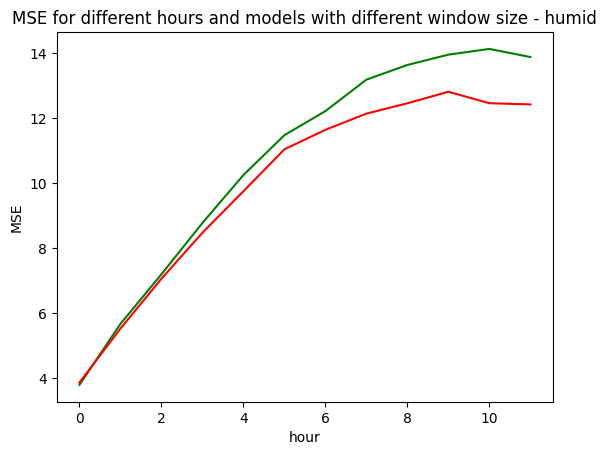

In [26]:
# plt.plot(MAE_humid_6,'g')
# plt.plot(MAE_humid_12,'r')
# plt.title("MSE for different hours and models with different window size - humid")
# plt.xlabel("hour")
# plt.ylabel("MSE")

##  Training data save

In [31]:
# # relh	 skph 	temp
# data = pd.DataFrame()
# data['MAE_humid_6'] = MAE_humid_6
# data['MAE_wind_6'] = MAE_wind_6
# data['MAE_temp_6'] = MAE_temp_6
# data['MAE_humid_12'] = MAE_humid_12
# data['MAE_wind_12'] = MAE_wind_12
# data['MAE_temp_12'] = MAE_temp_12

# data.to_csv("data_each_30_min")

# model 12 steps for 3 hours

In [10]:
test_size = 0.15
valid_size = 0.15
epochs = 12
learning_rate=0.001

window_size = 12
MSE_humid_12, MAE_humid_12, MSE_wind_12, MAE_wind_12, MSE_temp_12, MAE_temp_12, pred_12, actaul_12, bias_relh, bias_skph, bias_temp  = return_time(window_size,test_size,valid_size,epochs,learning_rate, True)

Epoch 1/12
789/789 [==============================] - 25s 23ms/step - loss: 0.1930 - root_mean_squared_error: 0.4393 - val_loss: 0.1270 - val_root_mean_squared_error: 0.3564
Epoch 2/12
789/789 [==============================] - 18s 23ms/step - loss: 0.1181 - root_mean_squared_error: 0.3436 - val_loss: 0.1150 - val_root_mean_squared_error: 0.3391
Epoch 3/12
789/789 [==============================] - 17s 22ms/step - loss: 0.1132 - root_mean_squared_error: 0.3364 - val_loss: 0.1134 - val_root_mean_squared_error: 0.3368
Epoch 4/12
789/789 [==============================] - 17s 21ms/step - loss: 0.1108 - root_mean_squared_error: 0.3328 - val_loss: 0.1103 - val_root_mean_squared_error: 0.3321
Epoch 5/12
789/789 [==============================] - 14s 17ms/step - loss: 0.1098 - root_mean_squared_error: 0.3313 - val_loss: 0.1085 - val_root_mean_squared_error: 0.3293
Epoch 6/12
789/789 [==============================] - 13s 17ms/step - loss: 0.1089 - root_mean_squared_error: 0.3300 - val_loss: 0

In [67]:
test_size = 0.15
valid_size = 0.15
epochs = 12
learning_rate=0.001

X_train, y_train, X_val, y_val, X_test, y_test, training_mean, training_std = transform_and_split_data(all_data.copy(), window_size, test_size, valid_size, 0)

In [68]:
print(training_mean)
print(training_std)

[76.89510779021957, 11.843569852039936, 9.335968539408992]
[18.583363048546722, 7.771864068320906, 8.958479911528652]


In [2]:
mean_and_std = pd.DataFrame()
mean_and_std['mean'] = training_mean
mean_and_std['std'] = training_std

mean_and_std.to_csv("mean_and_std")

### Bias - only for three  hours here

In [55]:
print(bias_relh)
print(bias_skph)
print(bias_temp)

[0.4184619806264121, 1.0857631600939683, 1.3110530625794459]
[-0.04263697249568254, -0.345274304003321, -0.5716397467405326]
[-0.21242941254435288, -0.5754088453565073, -0.22380083935642356]


In [56]:
# relh	 skph 	temp
biases = pd.DataFrame()
biases['humid'] = bias_relh
biases['wind'] = bias_skph
biases['temp'] = bias_temp

In [58]:
biases

,humid,wind,temp
0,0.418462,-0.042637,-0.212429
1,1.085763,-0.345274,-0.575409
2,1.311053,-0.571640,-0.223801


In [ ]:
for i in range(3):
        file_name = "lstm_" + (str)(i+1) + ".pkl"
        print(file_name)
        with open(file_name, "ab") as f_1:
                pickle.dump(biases[all_data.index==i], f_1, -1)